## Setup

In [48]:
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Initializing

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
# Image dimensions
IMG_HEIGHT = 250
IMG_WIDTH = 200
IMG_CHANNELS = 3
BATCH_SIZE = 64
NUM_CLASSES = 10
EPOCHS = 5

# Paths
train_data_dir = "Data/spectrogram_images/genres_original"

## Data Loading

In [37]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = ImageFolder(train_data_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [38]:
validation_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
validation_dataset = ImageFolder(train_data_dir, transform=validation_transform)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

## Model Setup and Training

In [39]:
# Model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(IMG_CHANNELS, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(32 * (IMG_HEIGHT // 8) * (IMG_WIDTH // 8), 64)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(32, 16)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(16, NUM_CLASSES)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.bn1(x)

        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.bn2(x)

        x = self.pool3(nn.functional.relu(self.conv3(x)))
        x = self.bn3(x)

        x = self.flatten(x)

        x = nn.functional.relu(self.fc1(x))
        x = self.dropout1(x)

        x = nn.functional.relu(self.fc2(x))
        x = self.dropout2(x)

        x = nn.functional.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc4(x)

        return x

In [40]:
# Create an instance of the model and move it to the GPU
model = Net().to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

In [41]:
# Train the model
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(validation_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/5, Train Loss: 2.6574, Train Accuracy: 0.1092, Validation Loss: 2.3199, Validation Accuracy: 0.1082
Epoch 2/5, Train Loss: 2.4257, Train Accuracy: 0.1132, Validation Loss: 2.3128, Validation Accuracy: 0.1002
Epoch 3/5, Train Loss: 2.3523, Train Accuracy: 0.1132, Validation Loss: 2.3139, Validation Accuracy: 0.1012
Epoch 4/5, Train Loss: 2.3146, Train Accuracy: 0.1283, Validation Loss: 2.3052, Validation Accuracy: 0.1172
Epoch 5/5, Train Loss: 2.2920, Train Accuracy: 0.1343, Validation Loss: 2.3001, Validation Accuracy: 0.1273


In [42]:
# Save the trained model
torch.save(model.state_dict(), r"Model/model.pth")

In [43]:
# Model summary
print(f'{"-"*100}\nModel:\n{model}\n{"-"*100}\nTraining completed!')

----------------------------------------------------------------------------------------------------
Model:
Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=24800, out_features=64, bias=True)
  (dropout1): Dropout(p

## Results

In [34]:
# Load the trained model
model = Net()
model.load_state_dict(torch.load(r"Model/model.pth"))
model.eval()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=99200, out_features=64, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.5

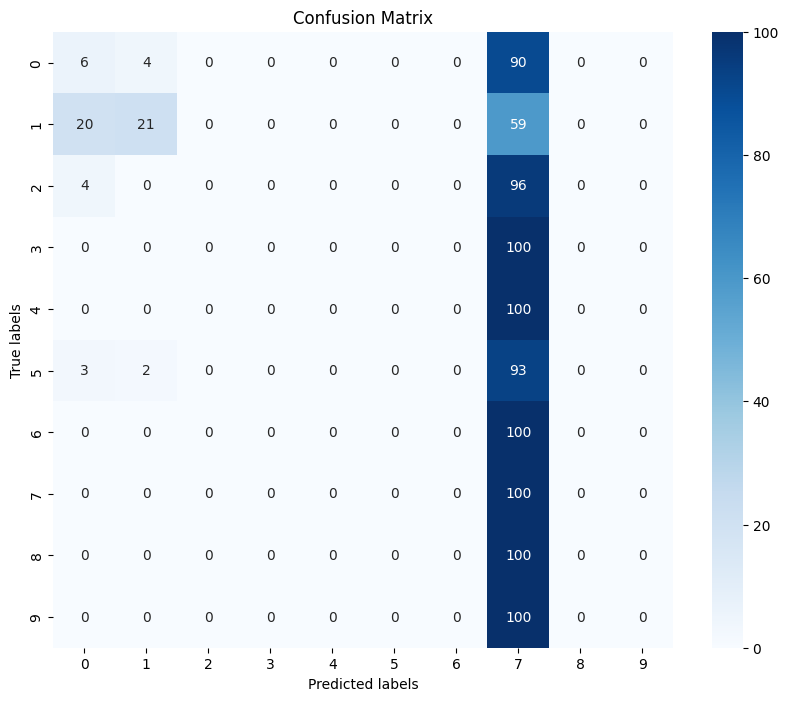

In [45]:
# Initialize the lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Predict labels for validation dataset
with torch.no_grad():
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

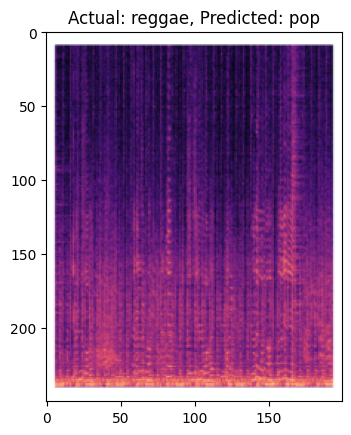

In [52]:
# Get class names
class_names = train_dataset.classes

# Choose a random image from validation dataset
random_idx = random.randint(0, len(validation_dataset)-1)
input_img, actual_label = validation_dataset[random_idx]

# Add a batch dimension
input_img = input_img.unsqueeze(0)

# Move image to GPU
input_img = input_img.to(device)

# Make prediction
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(input_img)
predicted_label = output.argmax(dim=1).item()

# Get the actual and predicted names
actual_name = class_names[actual_label]
predicted_name = class_names[predicted_label]

# Show the image

# Get mean and std
mean = np.array([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
std = np.array([0.229, 0.224, 0.225]).reshape(-1, 1, 1)

# Denormalize image
input_img_denormalized = std * input_img[0].cpu().numpy() + mean

# Make sure values are in [0,1] range and transpose
input_img_denormalized = np.clip(input_img_denormalized, 0, 1)
input_img_denormalized = np.transpose(input_img_denormalized, (1, 2, 0))

plt.imshow(input_img_denormalized)
plt.title(f"Actual: {actual_name}, Predicted: {predicted_name}")
plt.show()
